We currently have a model that can deal with one character of previous context. But the precition was not good enough.

* More context? way too many rows => expensive to calculate
* MLP

In [1]:
import torch
import torch.nn.functional as F

# Data

In [2]:
names = open("names.txt").read().splitlines()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
vocab = sorted(set(''.join(names)))
vocab = ["."] + vocab
len(vocab)

27

In [4]:
stoi = {s:i for i, s in enumerate(vocab)}
itos = {i:s for s, i in stoi.items()}

In [5]:
block_size = 5 # context length
xs, ys = [], []

for name in names[:5]:
    context = [0] * block_size
    print(name)
    for ch in name+".":
        idx = stoi[ch]
        xs.append(context)
        ys.append(idx)
        print(f"{''.join([itos[i] for i in context])} -------> {itos[idx]}")
        context = context[1:] + [idx]
xs, ys = torch.tensor(xs), torch.tensor(ys)

emma
..... -------> e
....e -------> m
...em -------> m
..emm -------> a
.emma -------> .
olivia
..... -------> o
....o -------> l
...ol -------> i
..oli -------> v
.oliv -------> i
olivi -------> a
livia -------> .
ava
..... -------> a
....a -------> v
...av -------> a
..ava -------> .
isabella
..... -------> i
....i -------> s
...is -------> a
..isa -------> b
.isab -------> e
isabe -------> l
sabel -------> l
abell -------> a
bella -------> .
sophia
..... -------> s
....s -------> o
...so -------> p
..sop -------> h
.soph -------> i
sophi -------> a
ophia -------> .


In [6]:
xs.shape, xs.dtype, ys.shape, ys.dtype

(torch.Size([32, 5]), torch.int64, torch.Size([32]), torch.int64)

# Embedding

Our vocab size is 27 and we want to map them into 2-D space. In original paper from Bengio, they have 17,000 words and then map them into 30-D space.

In [7]:
C = torch.randn([27, 2])
C

tensor([[-0.0455,  2.1932],
        [ 0.7252,  0.3142],
        [ 0.4269, -0.3342],
        [ 0.0788, -1.1889],
        [ 0.1104,  0.5757],
        [-0.2223,  0.1611],
        [ 0.0912, -1.4971],
        [-0.6341, -0.6525],
        [ 1.9947, -0.2577],
        [-1.7833, -0.1239],
        [ 0.3382, -0.2327],
        [-0.7605, -0.5295],
        [-0.3781,  1.2775],
        [-1.4518,  0.5570],
        [-0.2646, -0.1245],
        [-0.6150,  0.2805],
        [-1.2806, -1.1316],
        [-0.0167, -0.0672],
        [ 1.4898, -2.0974],
        [ 0.7647, -0.5168],
        [-1.1427,  1.3551],
        [ 1.5232,  0.9650],
        [-0.8693, -2.0321],
        [ 1.4359,  0.4247],
        [ 1.2453, -1.1552],
        [ 0.3348,  1.4309],
        [-0.4541, -1.1242]])

In [8]:
xenc = F.one_hot(torch.tensor(5), num_classes=27).float()
# which is equal to C[5]
# 5 th row will be plucked out.
C[5], C[5] == xenc @ C

(tensor([-0.2223,  0.1611]), tensor([True, True]))

In [9]:
xs

tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  5],
        [ 0,  0,  0,  5, 13],
        [ 0,  0,  5, 13, 13],
        [ 0,  5, 13, 13,  1],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 15],
        [ 0,  0,  0, 15, 12],
        [ 0,  0, 15, 12,  9],
        [ 0, 15, 12,  9, 22],
        [15, 12,  9, 22,  9],
        [12,  9, 22,  9,  1],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1],
        [ 0,  0,  0,  1, 22],
        [ 0,  0,  1, 22,  1],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  9],
        [ 0,  0,  0,  9, 19],
        [ 0,  0,  9, 19,  1],
        [ 0,  9, 19,  1,  2],
        [ 9, 19,  1,  2,  5],
        [19,  1,  2,  5, 12],
        [ 1,  2,  5, 12, 12],
        [ 2,  5, 12, 12,  1],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 19],
        [ 0,  0,  0, 19, 15],
        [ 0,  0, 19, 15, 16],
        [ 0, 19, 15, 16,  8],
        [19, 15, 16,  8,  9],
        [15, 16,  8,  9,  1]])

In [10]:
C[xs].shape, C[xs][1, 4], C[xs][1, 4] == C[5] 

(torch.Size([32, 5, 2]), tensor([-0.2223,  0.1611]), tensor([True, True]))

In [11]:
emb = C[xs]
emb.shape

torch.Size([32, 5, 2])

# Hidden Layer

In [12]:
W = torch.randn([10, 100])
emb @ W

RuntimeError: mat1 and mat2 shapes cannot be multiplied (160x2 and 10x100)

In [13]:
# Method 1: Extract and concat
concated_1 = torch.concat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :], emb[:, 3, :], emb[:, 4, :]), dim=1)
(concated_1 @ W).shape

torch.Size([32, 100])

In [14]:
# Method 2: Unbind
unbind_emb = torch.unbind(emb, dim=1)
concated_2 = torch.concat(unbind_emb, dim=1)
(concated_2 @ W).shape

torch.Size([32, 100])

In [15]:
# Method 3: View
viewed_emb = emb.view(32, -1)
concated_1 == concated_2, concated_1 == viewed_emb

(tensor([[True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
      

In [16]:
b = torch.rand(100)
hidden = emb.view(32, -1) @ W + b # b is broadcasted. emb: [32, 100] b: [1, 100] -> [32, 100]
hiddden_out = torch.tanh(hidden)
hiddden_out.shape

torch.Size([32, 100])

# Output Layer

In [17]:
W2 = torch.randn([100, 27])
b2 = torch.randn(27)
logits = hiddden_out @ W2 + b2

Previously how we did

In [18]:
logits = hiddden_out @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape, probs[0].sum()

(torch.Size([32, 27]), tensor(1.0000))

In [19]:
output = probs[torch.arange(32), ys] # Output prob at correct position, ideally all of them should be 1
output.shape, output

(torch.Size([32]),
 tensor([3.0119e-08, 2.8375e-02, 6.1374e-06, 9.3671e-12, 2.1485e-11, 1.6045e-17,
         1.4678e-11, 1.0807e-05, 3.6728e-13, 7.2138e-11, 1.8460e-16, 1.2394e-12,
         3.0063e-06, 7.5841e-08, 4.5854e-14, 4.4765e-13, 1.0614e-06, 2.8768e-04,
         2.5712e-09, 7.3569e-07, 3.6548e-05, 3.3603e-07, 1.1610e-13, 4.6365e-08,
         8.7782e-12, 6.7819e-07, 2.0970e-18, 6.5958e-05, 9.5083e-08, 2.3348e-06,
         1.5352e-14, 3.4778e-10]))

In [20]:
loss = -output.log().mean()
loss

tensor(20.6906)

More efficient in torch

In [21]:
test_x = torch.tensor([-5, 5, 100])
how_torch_did_test_x = test_x - 100
test_x.exp(), how_torch_did_test_x.exp()

(tensor([6.7379e-03, 1.4841e+02,        inf]),
 tensor([0.0000e+00, 5.5211e-42, 1.0000e+00]))

In [22]:
loss_torch = F.cross_entropy(logits, ys)
loss_torch

tensor(20.6906)

# Put above together

In [23]:
block_size = 5 # context length
xs, ys = [], []

for name in names:
    context = [0] * block_size
#     print(name)
    for ch in name+".":
        idx = stoi[ch]
        xs.append(context)
        ys.append(idx)
#         print(f"{''.join([itos[i] for i in context])} -------> {itos[idx]}")
        context = context[1:] + [idx]
xs, ys = torch.tensor(xs), torch.tensor(ys)

In [24]:
xs.shape, ys.shape

(torch.Size([228146, 5]), torch.Size([228146]))

In [25]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn([27, 2], generator=g) # 32x5x27 * 27* 2 => 32x5x2
W1 = torch.randn([10, 100], generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn([100, 27], generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [26]:
sum(p.nelement() for p in parameters)

3881

## Too slow for training entire dataset one time
Minibatch would be helpful

In [27]:
steps = 1000
for step in range(steps):
    # Minibatch construct
    # Randomly sample from xs
    # Sample 32 samples from all xs indices
    idx = torch.randint(0, xs.shape[0], (32,))
    
    # Fordward Pass
    emb = C[xs[idx]]
    h = torch.tanh(emb.view(-1, 10) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys[idx])
    if step % 100 == 0:
        print(f"Step: {step}/{steps}, loss: {loss.item()}")

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    with torch.no_grad():
        for p in parameters:
            p += -0.1 * p.grad

Step: 0/1000, loss: 18.271120071411133
Step: 100/1000, loss: 4.092945575714111
Step: 200/1000, loss: 4.093234539031982
Step: 300/1000, loss: 2.9588305950164795
Step: 400/1000, loss: 2.6177566051483154
Step: 500/1000, loss: 2.6725914478302
Step: 600/1000, loss: 2.8950424194335938
Step: 700/1000, loss: 3.291722536087036
Step: 800/1000, loss: 2.7646677494049072
Step: 900/1000, loss: 2.845332384109497


In [28]:
# Prediction
logits.max(dim=1)

torch.return_types.max(
values=tensor([1.7934, 3.4503, 0.5628, 0.5628, 0.5628, 3.3070, 0.5628, 1.8333, 3.2334,
        2.2058, 1.1458, 0.3604, 2.4072, 2.4955, 0.5962, 0.1966, 0.2286, 2.8110,
        3.3311, 2.4573, 0.5628, 1.3727, 2.7784, 3.1037, 1.0380, 0.5628, 1.9523,
        1.6512, 0.5628, 1.9523, 0.5628, 0.5628], grad_fn=<MaxBackward0>),
indices=tensor([ 0,  0, 19, 19, 19,  0, 19,  1,  0,  1,  1, 18, 19, 14, 18, 25,  1,  1,
         0,  1, 19, 15,  1,  0,  1, 19,  1,  1, 19,  1, 19, 19]))

In [29]:
# Label
ys[idx]

tensor([18,  0, 11, 14, 22,  5, 11,  1,  0,  5, 18, 14, 14,  8, 12, 13, 14, 15,
         0,  1, 19,  1,  1, 14, 14,  3,  1, 18,  3,  1, 20,  5])

In [30]:
# Loss over all samples
emb = C[xs]
h = torch.tanh(emb.view(-1, 10) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ys)
loss

tensor(2.6527, grad_fn=<NllLossBackward0>)

## Loss decrease slow
Find a better learning rate

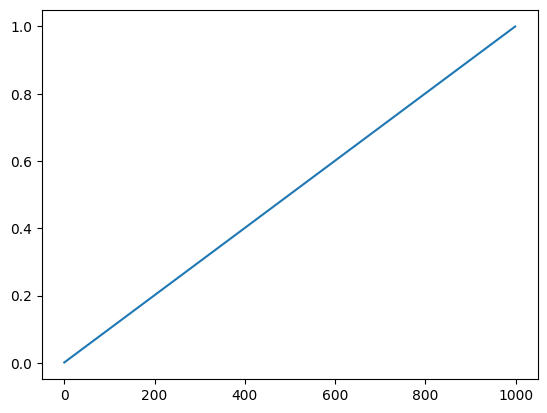

In [31]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(1000), torch.linspace(0.001, 1, 1000))

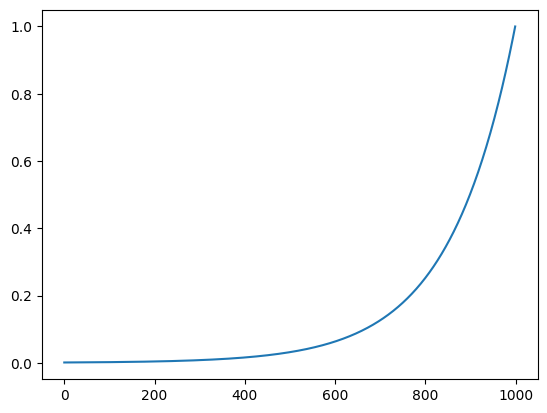

In [32]:
plt.plot(torch.arange(1000), 10 ** torch.linspace(-3, 0, 1000))

In [37]:
import math
steps = 1000
lre = torch.linspace(-3, 0, 1000)
lrs = 10 **lre
lri = []
lossi = []

for step in range(steps):
    # Minibatch construct
    # Randomly sample from xs
    # Sample 32 samples from all xs indices
    idx = torch.randint(0, xs.shape[0], (32,))
    
    # Fordward Pass
    emb = C[xs[idx]]
    h = torch.tanh(emb.view(-1, 10) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys[idx])
#     if step % 100 == 0:
#         print(f"Step: {step}/{steps}, loss: {loss.item()}")
    
    lr = lrs[step]
    lri.append(math.log(lr,10))
    lossi.append(loss.item())
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    with torch.no_grad():
        for p in parameters:
            p += -0.01 * p.grad

In [38]:
# Loss over all samples
emb = C[xs]
h = torch.tanh(emb.view(-1, 10) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ys)
loss

tensor(2.4554, grad_fn=<NllLossBackward0>)

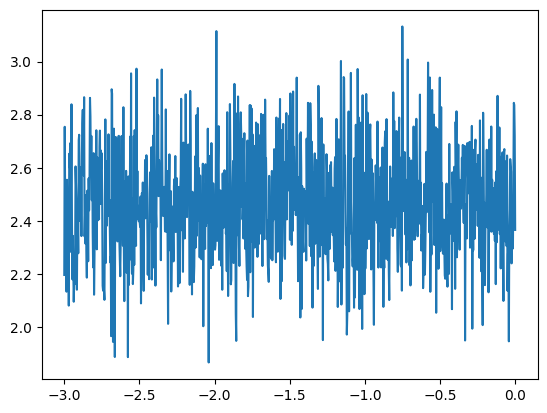

In [39]:
# Then pick lr = 10 ** -1.0
plt.plot(lri, lossi)

## Better evaluation
Train 80%, Validation 10%, Test 10%

In [45]:
import random
def build_dataset(words):
    block_size = 3 # context length
    xs, ys = [], []

    for word in words:
        context = [0] * block_size
        for ch in word+".":
            idx = stoi[ch]
            xs.append(context)
            ys.append(idx)
            context = context[1:] + [idx]
    xs, ys = torch.tensor(xs), torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys

random.seed(42)
random.shuffle(names)
train_idx = int(0.8 * len(names))
val_idx = int(0.9 * len(names))
print(f"Training names: {train_idx}, Validation names: {val_idx-train_idx}, Test names: {len(names)-val_idx}")

print("--------------Training sample with context----------")
x_train, y_train = build_dataset(names[:train_idx])
print("--------------Validation sample with context----------")
x_val, y_val = build_dataset(names[train_idx:val_idx])
print("--------------Test sample with context----------")
x_test, y_test = build_dataset(names[val_idx:])

Training names: 25626, Validation names: 3203, Test names: 3204
--------------Training sample with context----------
torch.Size([182580, 3]) torch.Size([182580])
--------------Validation sample with context----------
torch.Size([22767, 3]) torch.Size([22767])
--------------Test sample with context----------
torch.Size([22799, 3]) torch.Size([22799])


* Solve Underfitting with wider hidden layer
* Larger embedding

In [46]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn([27, 10], generator=g) # 32x3x27 * 27* 10 => 32x3x10
W1 = torch.randn([30, 200], generator=g) # Larger embedding and wider hidden layer
b1 = torch.randn(200, generator=g)
W2 = torch.randn([200, 27], generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [47]:
import math
steps = 200000

for step in range(steps):
    idx = torch.randint(0, x_train.shape[0], (32,))
    
    # Fordward Pass
    emb = C[x_train[idx]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[idx])
    
    lr = 0.1 if step < 100000 else 0.01
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    with torch.no_grad():
        for p in parameters:
            p += -lr * p.grad

In [49]:
# Loss over all training samples
emb = C[x_train]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.1188, grad_fn=<NllLossBackward0>)

In [50]:
# Loss over all val samples
emb = C[x_val]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.1564, grad_fn=<NllLossBackward0>)

* 2.2912 for train and 2.2965 for val on 100 neurons per layer and 2 emb, 5 context
* 2.2361 for train and 2.2514 for val on 300 neurons per layer and 2 emb, 5 context
* 2.1860 for train and 2.2068 for val on 300 neurons per layer and 10 emb, 5 context
* 2.1188 for train and 2.1564 for val on 200 neurons per layer and 10 emb, 3 context

## Visualize emb and scale up emb dim
similar character will cluster together.

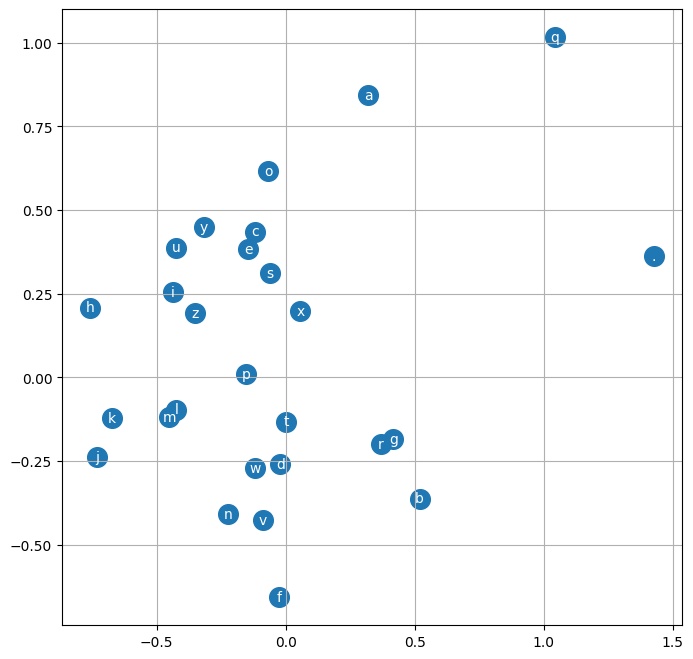

In [51]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

# Sampling from the model

In [101]:
block_size = 3


g = torch.Generator().manual_seed(2147483647 + 10)
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # 3x10
        h = torch.tanh(emb.view(1, -1)  @ W1 + b1)
        logits = h @ W2 + b2

        # Not choose by argmax
        probs = F.softmax(logits, dim=1)
        next_idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [next_idx]
        out.append(next_idx)
        if next_idx == 0:
            break
    
    print(''.join([itos[i] for i in out]))

carmah.
aabylle.
haimrighte.
caspansh.
esrahnen.
den.
rha.
kaqui.
ner.
kentzeriir.
kaleigh.
ham.
pristen.
juza.
lilea.
jadiquintero.
dearynix.
kael.
ivrathen.
edi.
